# Семинар: Задача Кластеризации (Clustering)

In [1]:
import matplotlib.pyplot as plt
import matplotlib        as mpl

import pandas as pd
import numpy  as np
import scipy  as sp

import itertools

from sklearn.cluster          import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg             import eigh

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

try:
    from sklearn.datasets import make_blobs
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.datasets import make_blobs

from sklearn.cluster   import KMeans
from sklearn.cluster   import MiniBatchKMeans
from sklearn.datasets  import make_blobs
from sklearn.metrics   import silhouette_samples
from sklearn.metrics   import silhouette_score

from matplotlib.patches import Ellipse

from sklearn import mixture

from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib        import cm

from tqdm   import tqdm
from timeit import timeit

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Полезные функции для отрисовки

In [2]:
def plot_silhouette(model, X):
    mu = model.cluster_centers_
    K, D = mu.shape
    y_pred = model.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_scores = silhouette_score(X, model.labels_)
    cmap = cm.get_cmap("Pastel2")
    colors = [cmap(i) for i in range(K)]
    padding = len(X) // 30
    pos = padding
    for i in range(K):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / K)
        # color = colors[i]
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        pos += len(coeffs) + padding
    score = silhouette_scores
    plt.axvline(x=score, color="red", linestyle="--")
    plt.title("$k={}, score={:0.2f}$".format(K, score), fontsize=16)
    
def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="o", s=30, linewidths=8, color=circle_color, zorder=10, alpha=0.9
    )
    plt.scatter(
        centroids[:, 0], centroids[:, 1], marker="x", s=50, linewidths=50, color=cross_color, zorder=11, alpha=1
    )

def plot_decision_boundaries(model, X, resolution=1000):
    mu = model.cluster_centers_
    K, D = mu.shape
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap = "Pastel2"
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap=cmap)
    plt.contour (Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k")
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    plot_centroids(model.cluster_centers_)
    plt.title(f"K={K}")
    
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    elif np.isscalar(covariance):
        angle = 0
        width, height = 2 * np.sqrt(covariance), 2 * np.sqrt(covariance)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    
    plt.title("$k={}$".format(gmm.n_components), fontsize=16)

In [3]:
blob_centers = np.array([[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

K = 30

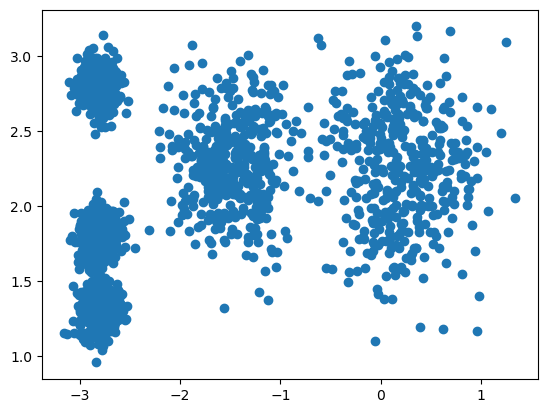

In [4]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## Алгоритм K-средних

### Описание алгоритма

Метод K-средних – это итеративный алгоритм, основанный на минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров.

- Шаг инициализации
    Мы каким-либо образом, например случайным, инициализируем центры кластеров ${\mu_k}^{(0)}, k = 1,K$

- Шаг распределение векторов $x_i$ по кластерам $C_k$:
    $$\forall x_i \in X, i = 1,N : x_i \in C_j \iff j = \underset{k}{argmin} ( \rho(x_i, {\mu_k}^{(t)} ) )$$
        
- Шаг пересчета центров кластеров ${\mu_k}^{(t+1)}$:
    $$ {\mu_k}^{(t+1)} = \dfrac{1}{|C_k|} \sum_{x_i \in C_k} x_i   $$


### Как оценить число кластеров?:

<details>
<summary> <strong>Ответ</strong> </summary>

Inertia score:

$$S = \sum_{i=1}^{I}\sum_{j=1}^{J_i}\|x_{ij} - \mu_i\|^2$$
    
    
Distortion score:
    
$$S = \sum_{i=1}^{I}\dfrac{\sum_{j=1}^{J_i}\|x_{ij} - \mu_i\|^2}{|C_i|}$$

Silhouette score:

$$a_i = \frac{1}{|C_I| - 1}\sum_{x_j \in C_I, x_i \neq x_j} d(x_i,x_j)$$

$$b_i = \min_{J \neq I} \frac{1}{|C_J|} \sum_{j \in C_J} d(x_i, x_j)$$
    
$$s_i = \begin{cases} \dfrac{b_i - a_i}{\max\{a_i, b_i\}} &, |C_i| > 1 \\ 0 &, |C_i| = 1 \end{cases}$$ 
    
</details>


## Сравнение реализаций

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.91it/s]


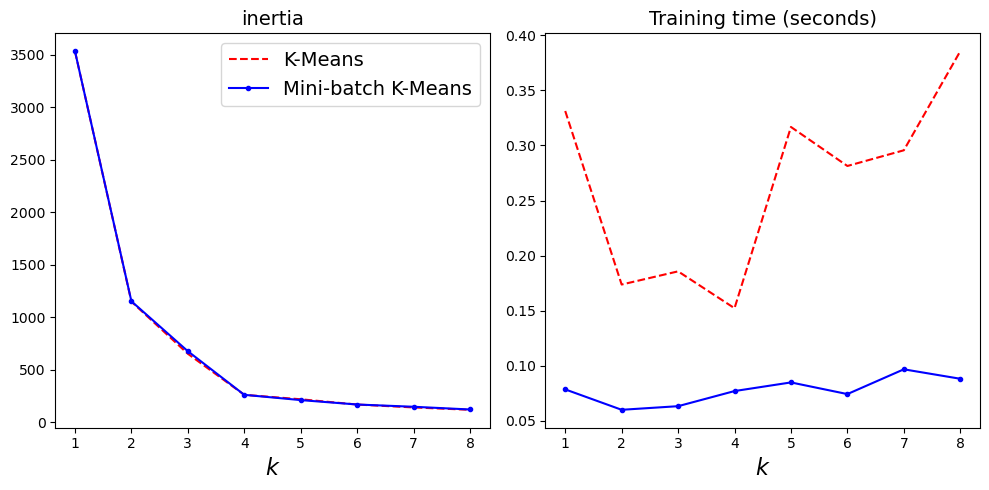

In [26]:
times = np.empty((K, 2))
inertias = np.empty((K, 2))
for k in tqdm( list(range(1, K + 1)) ):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(range(1, K + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, K + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("inertia", fontsize=14)
plt.legend(fontsize=14)
# plt.axis([1, K, 0, K])

plt.subplot(122)
plt.plot(range(1, K + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, K + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
# plt.axis([1, K, 0, 6])

plt.tight_layout()
plt.show()


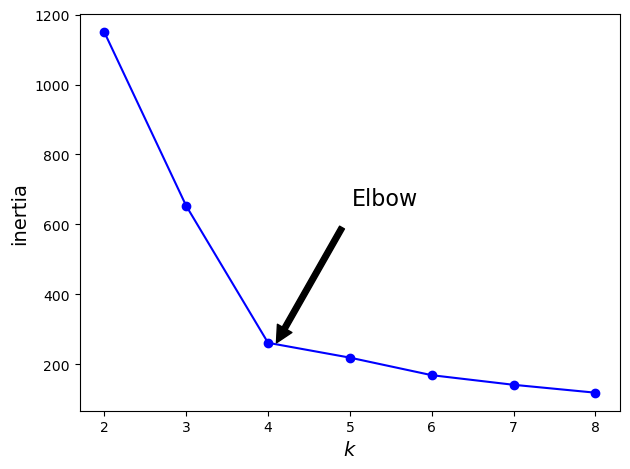

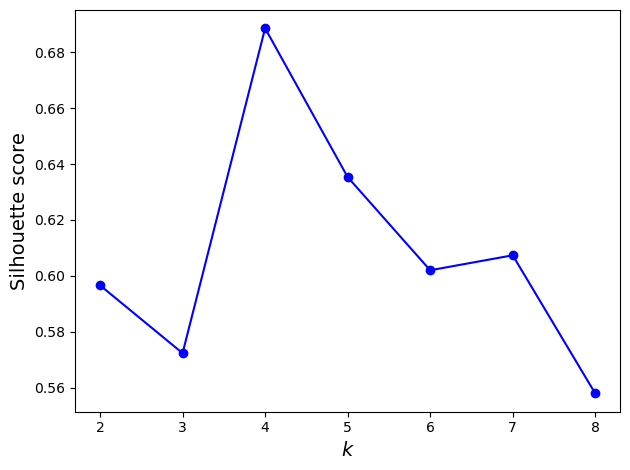

/var/folders/3c/zb3vq_6960dbkm_ndj8dmrk40000gn/T/ipykernel_83817/1246329691.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Pastel2")
/var/folders/3c/zb3vq_6960dbkm_ndj8dmrk40000gn/T/ipykernel_83817/1246329691.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Pastel2")
/var/folders/3c/zb3vq_6960dbkm_ndj8dmrk40000gn/T/ipykernel_83817/1246329691.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Pastel2")
/var/fo

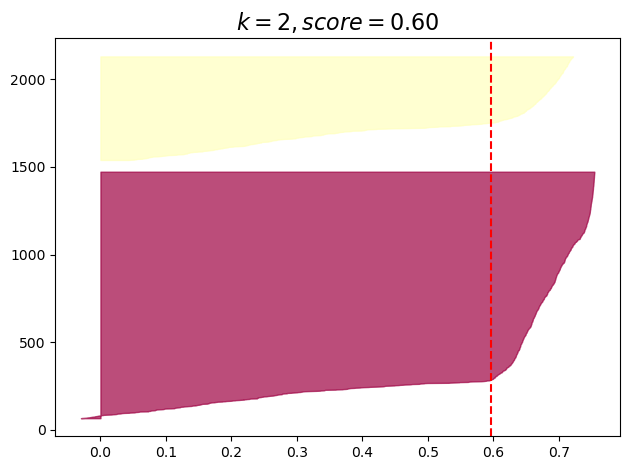

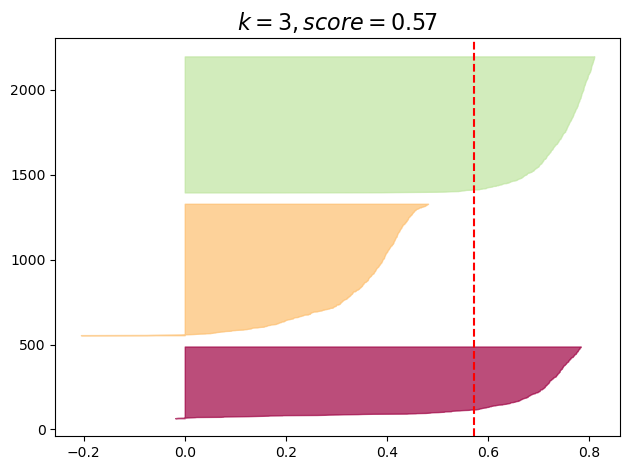

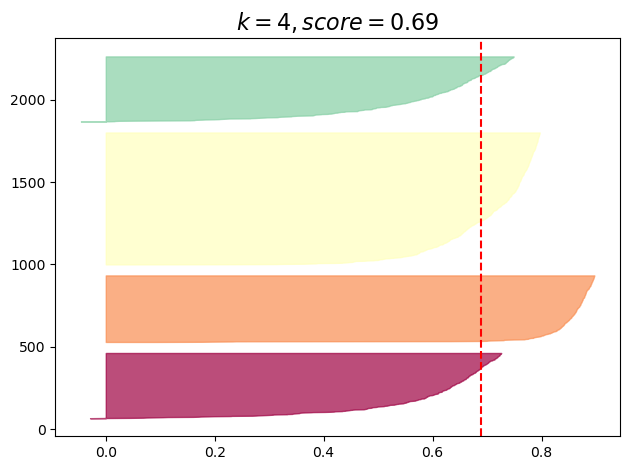

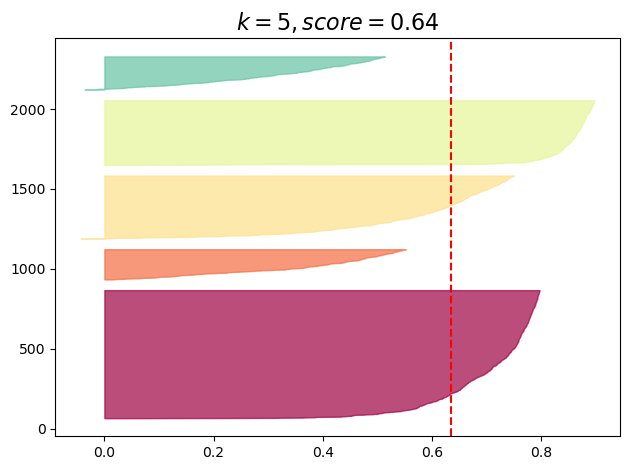

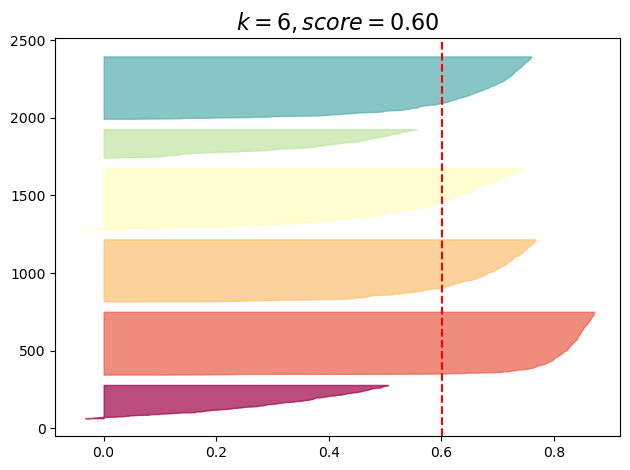

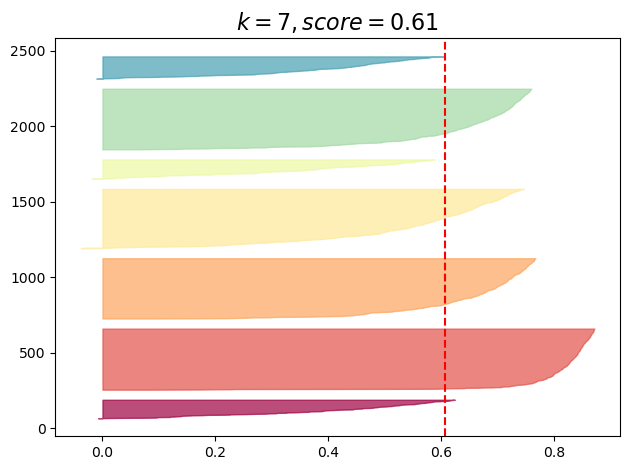

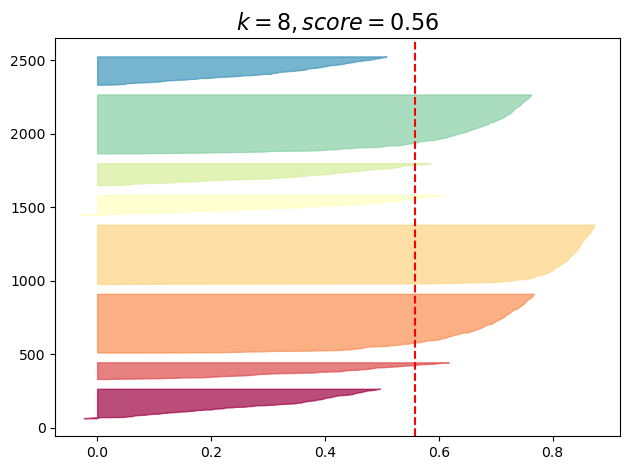

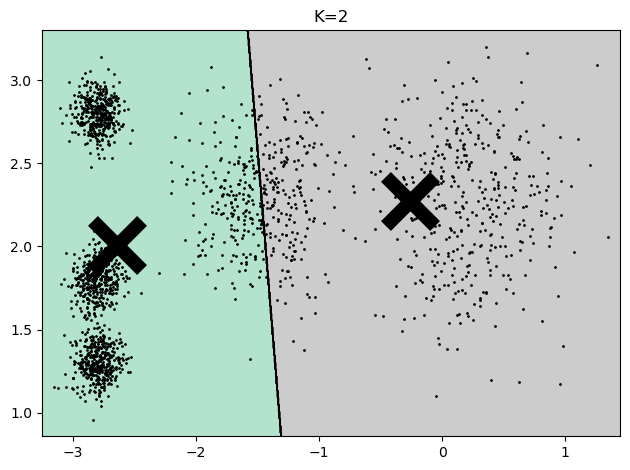

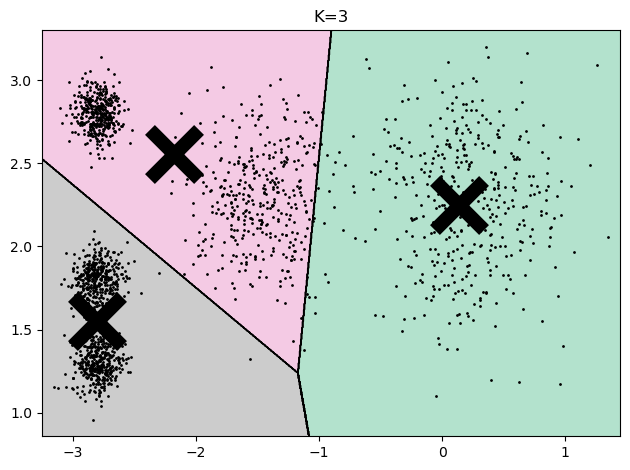

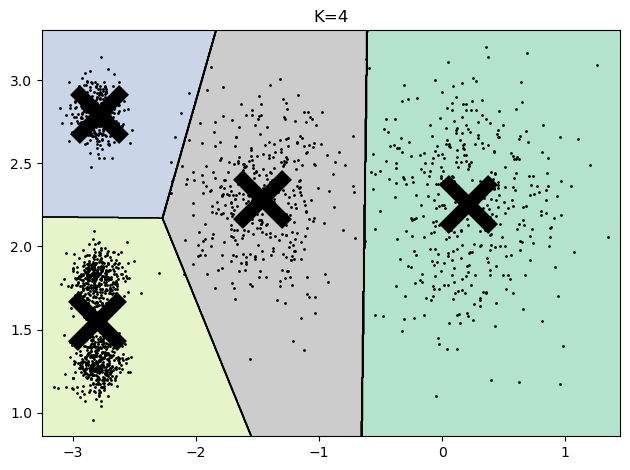

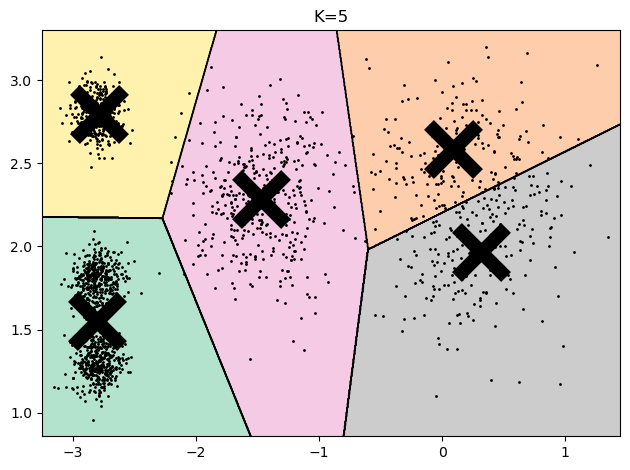

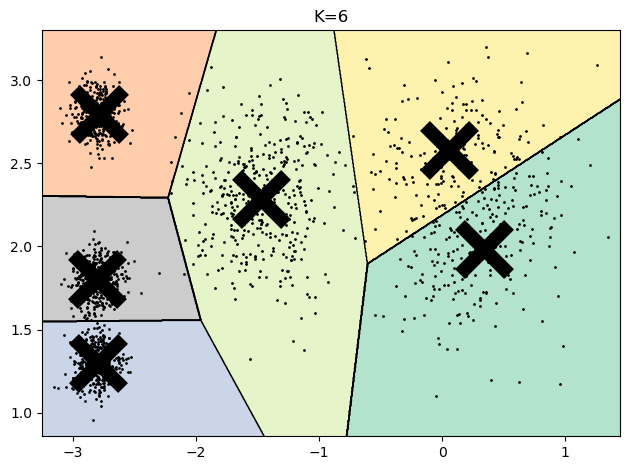

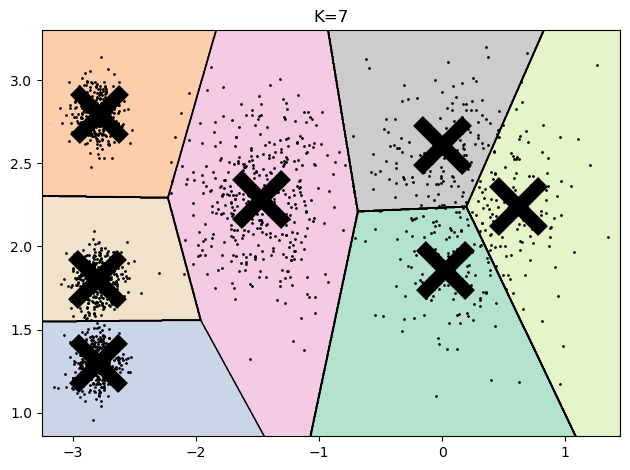

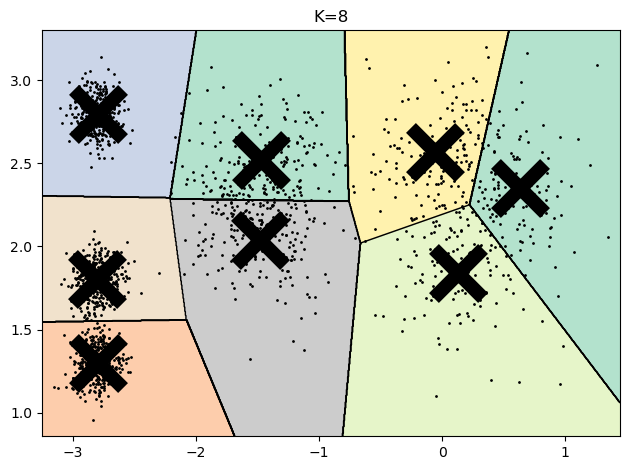

In [27]:
geron_data = True

K_s = range(2, 9)
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in K_s]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure()
plt.plot(K_s, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("inertia", fontsize=14)
if geron_data:
    plt.annotate(
        "Elbow",
        xy=(4, inertias[3]),
        xytext=(0.55, 0.55),
        textcoords="figure fraction",
        fontsize=16,
        arrowprops=dict(facecolor="black", shrink=0.1),
    )
plt.tight_layout()
plt.show()


silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k]

plt.figure()
plt.plot(K_s, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
plt.tight_layout()
plt.show()

for model in kmeans_per_k:
    K, D = model.cluster_centers_.shape
    plt.figure()
    plot_silhouette(model, X)
    plt.tight_layout()

for model in kmeans_per_k:
    K, D = model.cluster_centers_.shape
    plt.figure()
    plot_decision_boundaries(model, X)
    plt.tight_layout()


## Алгоритм Expectation Maximization

### Описание алгоритма EM (Expectation-Maximization)

$$ LL(\Theta) = \sum_{n = 1}^{N} \log P(y_n | \Theta) = \sum_{n = 1}^{N} \log \sum_{z_n} P(y_n, z_{n} | \Theta) = \sum_{n = 1}^{N} \log \sum_{z_n} q(z_n) \dfrac{P(y_n, z_{n} | \Theta) }{q(z_{n})}$$

$y_n$ - наблюдаемые значения, $z_{n}$ - скрытые переменные 

Используем [неравенство Йенсена](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D1%80%D0%B0%D0%B2%D0%B5%D0%BD%D1%81%D1%82%D0%B2%D0%BE_%D0%99%D0%B5%D0%BD%D1%81%D0%B5%D0%BD%D0%B0), тогда:

$$ \sum_{n = 1}^{N} \log \sum_{z_n} q(z_{n}) \dfrac{P(y_n, z_{n} | \Theta) }{q(z_{n})} \geq \sum_{n = 1}^{N} \sum_{z_n} q(z_{n}) \log \dfrac{P(y_n, z_{n} | \Theta) }{q(z_{n})}$$



- Шаг Expectation :
    
    $$\sum_{n = 1}^{N} \sum_{z_n} q(z_{n}) \log \dfrac{P(y_n, z_{n} | \Theta) }{q(z_{n})} = \sum_{n = 1}^{N} \sum_{z_n} q(z_{n}) \log \dfrac{P( z_{n} | y_n, \Theta)P( y_n | \Theta) }{q(z_{n})} = \sum_{n = 1}^{N} \sum_{z_n} \Big( q(z_{n}) \log \dfrac{P( z_{n} | y_n, \Theta) }{q(z_{n})} + q(z_{n}) \log P(y_n | \Theta)) \Big) = \\ = \sum_{n = 1}^{N} \sum_{z_n} q(z_{n}) \log \dfrac{P( z_{n} | y_n, \Theta) }{q(z_{n})} + \sum_{n = 1}^{N} \log P(y_n | \Theta))$$
    
$$q(z_{n})^{*} = P( z_{n} | y_n, \Theta)$$

- Шаг Maximization:
    
    $$\sum_{n = 1}^{N} \sum_{z_n} q(z_{n}) \log \dfrac{P(y_n, z_{n} | \Theta) }{q(z_{n})} = \sum_{n = 1}^{N} \underset{q(z_{n})}{\mathbb{E}}\log {P(y_n, z_{n} | \Theta) } + \mathbb{H}(q(z_{n}))$$
    
    $$ \Theta^{t+1} = \underset{\Theta}{argmax}\sum_{n = 1}^{N} \underset{q(z_{n})}{\mathbb{E}}\log {P(y_n, z_{n} | \Theta) } + \mathbb{H}(q(z_{n})) = \underset{\Theta}{argmax}\sum_{n = 1}^{N} \underset{q(z_{n})}{\mathbb{E}}\log {P(y_n, z_{n} | \Theta) }) $$

### Описание алгоритма [Gaussian Mixture Model](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html):

$$P(y_n | \mu_k, \Sigma_k) = \mathcal{N}(\mu_k, \Sigma_k)$$
$$z   \sim P( z  | \pi_1,...,\pi_K ) = \text{Multinomial Distribution} (\pi_1,...,\pi_K) $$
$$y_n \sim P(y_n | \pi_1,...,\pi_K, \mu_1, \Sigma_1 ..., \mu_K, \Sigma_K ) = \sum_{k=1}^{K} \pi_k P(y_n | \mu_k, \Sigma_k) $$

- Шаг инициализации
    Мы каким-либо образом, например, случайным, выбираем скрытые переменные, в нашем случае это будут вероятности $\pi_k$, математические ожидания — $\mu_k$ и 
    ковариационные матрицы — $\Sigma_k$, $k=1,...,K$.

- Шаг Expectation :
        
    Используя текущие значения $\pi_k$, $\mu_k$, $\Sigma_k$, рассчитываем вероятность отнесения каждого объекта к тому или иному кластеру. 
    
    Используем формулу Байеса:
    $$P(y|x) = \dfrac{P(y)P(x|y)}{P(x)}$$
    Тогда:
    
    $$r^{t}_{nk} = q^{t}(z_{n} = k)^{*} = P( z_{n} = k| y_n, \pi_1^{t},...,\pi_K^{t}, \mu_1^{t}, \Sigma_1^{t}, ..., \mu_K^{t}, \Sigma_K^{t}) = \dfrac{P(z_n = k | \pi_1^{t},...,\pi_K^{t}, \mu_1^{t}, \Sigma_1^{t}, ..., \mu_K^{t}, \Sigma_K^{t})P(y_n |z_n = k, \pi_1^{t},...,\pi_K^{t}, \mu_1^{t}, \Sigma_1^{t}, ..., \mu_K^{t}, \Sigma_K^{t} )}{P(y_n | \pi_1^{t},...,\pi_K^{t}, \mu_1^{t}, \Sigma_1^{t}, ..., \mu_K^{t}, \Sigma_K^{t})} = \dfrac{P(z_n = k | \pi_1^{t},...,\pi_K^{t})P(y_n |z_n = k, \pi_1^{t},...,\pi_K^{t}, \mu_1^{t}, \Sigma_1^{t}, ..., \mu_K^{t}, \Sigma_K^{t} )}{P(y_n | \pi_1^{t},...,\pi_K^{t}, \mu_1^{t}, \Sigma_1^{t}, ..., \mu_K^{t}, \Sigma_K^{t})} = \dfrac{\pi_{k}P(y_n | \mu_k^{t}, \Sigma_k^{t})}{\sum_{k^{'}}\pi_{k^{'}}^{t}P(y_n | \mu_{k^{'}}^{t}, \Sigma_{k^{'}}^{t})}$$
        
- Шаг Maximization:
    $$\underset{q(z_{nk})}{\mathbb{E}}\log {P(y_n, z_{n} | \pi_1,...,\pi_K, \mu_1, \Sigma_1, ..., \mu_K, \Sigma_K) } = \underset{q(z_{nk})}{\mathbb{E}}\Big( \log {P( z_{n} | \pi_1,...,\pi_K, \mu_1, \Sigma_1, ..., \mu_K, \Sigma_K) } + \log {P( y_{n} | z_{n}, \pi_1,...,\pi_K, \mu_1, \Sigma_1, ..., \mu_K, \Sigma_K) } \Big) = \underset{q(z_{nk})}{\mathbb{E}}\Big( \log {P( z_{n} | \pi_1,...,\pi_K) } + \log {P( y_{n} | z_{n}, \pi_1,...,\pi_K, \mu_1, \Sigma_1, ..., \mu_K, \Sigma_K) } \Big) = \underset{q(z_{nk})}{\mathbb{E}}\Big( \log { \prod_{k=1}^{K}\pi_k^{z_{nk}} } + \log { \prod_{k=1}^{K} (\mathcal{N}(\mu_k, \Sigma_k))^{z_nk}  } \Big)$$
    где $z_{nk} = \mathbb{I}(z_n = k)$
    $$\Downarrow$$
$$\mu_k^{t+1}    = \dfrac{\sum_{n=1}^{N} r^{t}_{nk} y_n}{                                            \sum_{n=1}^{N}r^{t}_{nk} }$$
$$\Sigma_k^{t+1} = \dfrac{\sum_{n=1}^{N} r^{t}_{nk} (y_n - \mu_k^{t+1})(y_n - \mu_k^{t+1})^{\top} }{ \sum_{n=1}^{N}r^{t}_{nk} }$$
$$\pi_k^{t+1}    = \dfrac{\sum_{n=1}^{N} r^{t}_{nk}}{N}$$

### Какие предположения требуется сделать, чтобы получить алгоритм K-means?

<details>
<summary> <strong>Ответ</strong> </summary>
    $$\Sigma_k = \mathbb{I}$$
    $$\pi_k = \dfrac{1}{K}$$
</details>
    
    

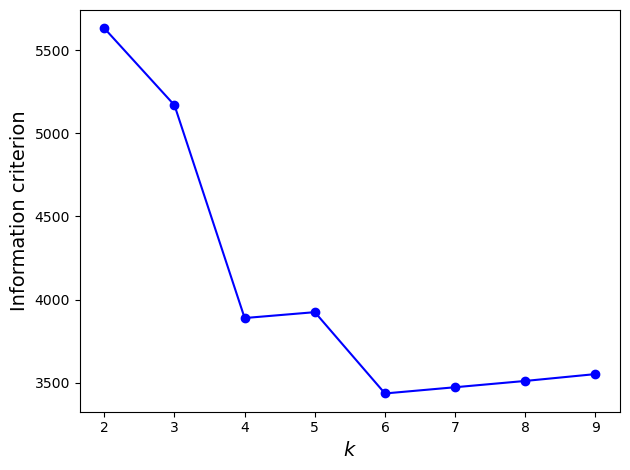

/var/folders/3c/zb3vq_6960dbkm_ndj8dmrk40000gn/T/ipykernel_83817/1246329691.py:66: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
/var/folders/3c/zb3vq_6960dbkm_ndj8dmrk40000gn/T/ipykernel_83817/1246329691.py:66: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
/var/folders/3c/zb3vq_6960dbkm_ndj8dmrk40000gn/T/ipykernel_83817/1246329691.py:66: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,
/var/fo

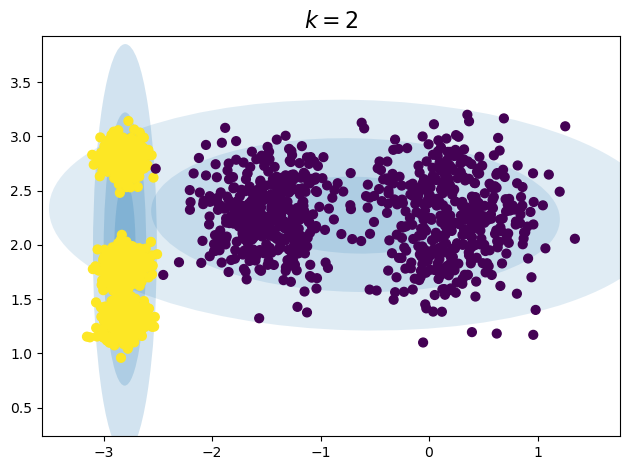

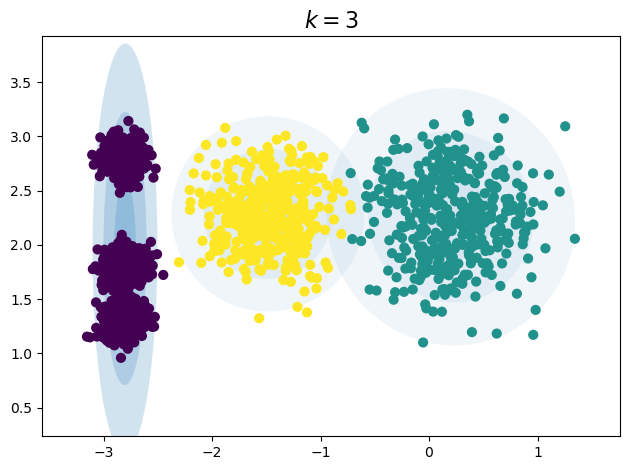

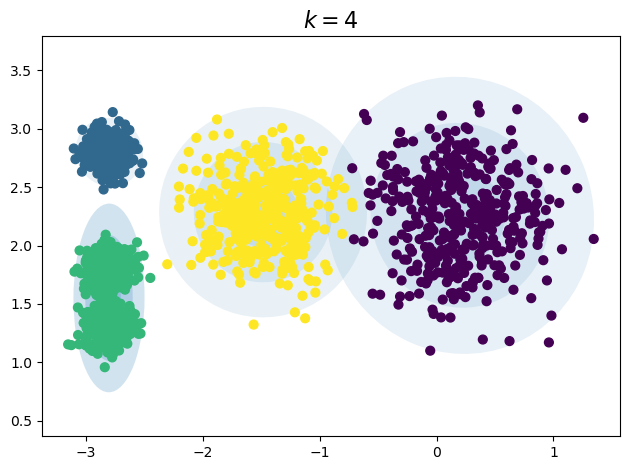

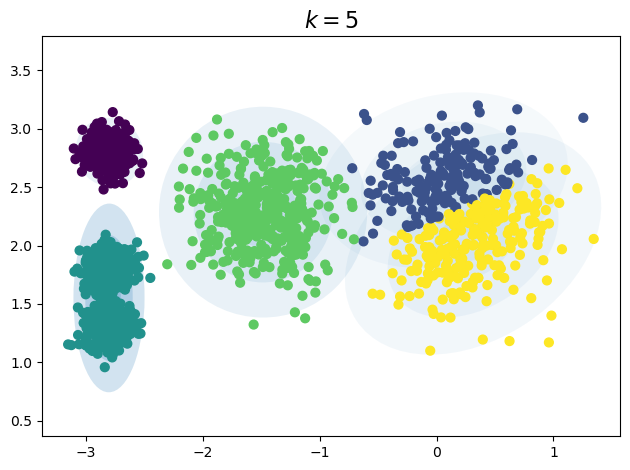

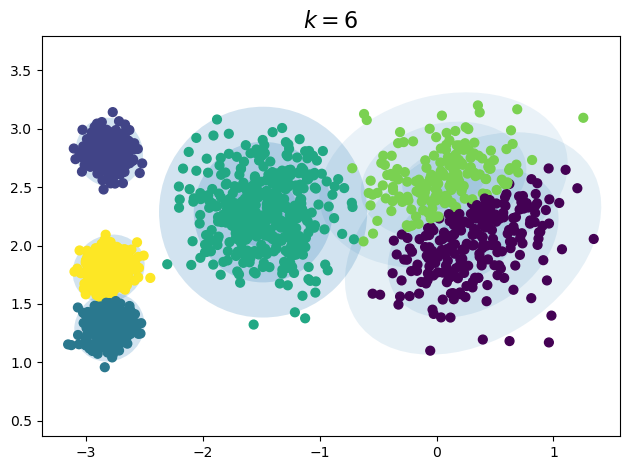

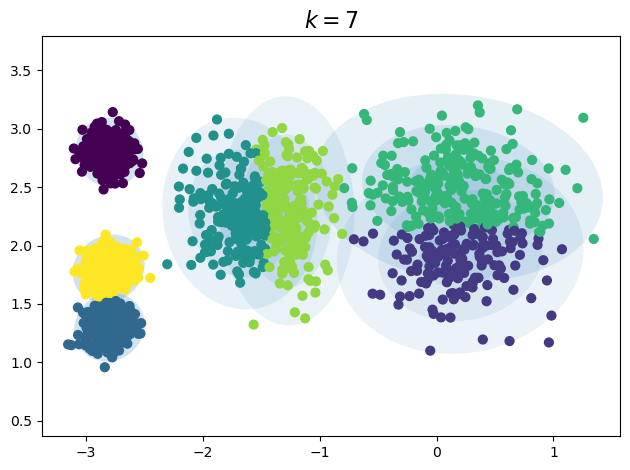

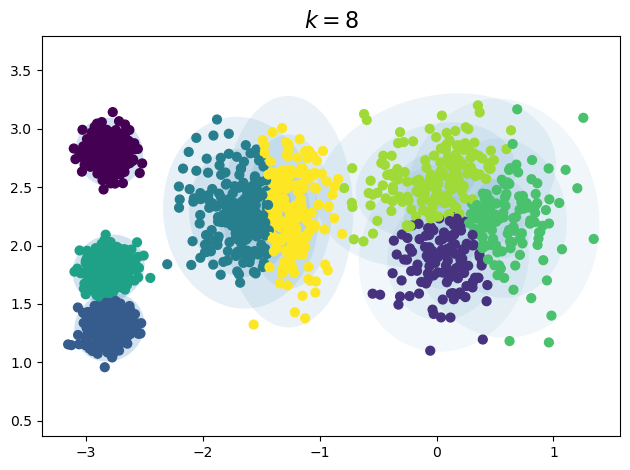

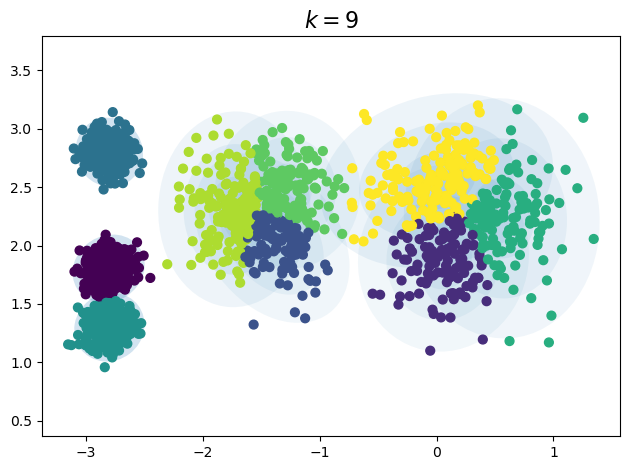

In [28]:
K_s = range(2, 10)
gmm_per_k = [mixture.GaussianMixture(n_components=k, n_init=10, init_params="kmeans", covariance_type='full', max_iter=1000, random_state=42).fit(X) for k in K_s]

bic_s = [model.bic(X) for model in gmm_per_k]
ais_s = [model.aic(X) for model in gmm_per_k]

plt.figure()
plt.plot(K_s, bic_s, "bo-")
# plt.plot(K_s, ais_s, "ro-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information criterion", fontsize=14)
plt.tight_layout()
plt.show()

for model in gmm_per_k:
    plt.figure()
    plot_gmm(model, X)
    plt.tight_layout()

## Кластеризация методами теории графов

Подход к кластеризации, основанный на анализе собственных значений матрицы парного сходства, использует собственные векторы для получения векторов признаков для каждой точки данных, которые затем кластеризуются с помощью метода кластеризации на основе признаков, например, K-средних. Этот метод известен как спектральная кластеризация.

![SpectralClustering_1](SpectralClustering_1.png)

Алгоритм Unnormalized Spectral Clustering

* Вычисление матрицы соседства A:
    * Соединяем все точки, парные расстояния между которыми меньше некоторого $\epsilon$
    * Соединяем точки с K-ближайшими соседями
    * Соединяем точки между собой, расстояние между точками $S(y_i,y_j) = \exp \Big(-\dfrac{\|y_i - y_j\|^2}{2 \sigma^2} \Big)$

* Вычисляем матрицу Лапласа $L = D-A$
* Вычисляем первые K - собственных вектора $v_1,...,v_K$ матрицы L, $Lv = {\lambda}v$
* Построим матрицу $V \in R^{n{\times}k}$ , где вектора $v_2, ..., v_K$ в качестве колонок.
* $x_i \in R^k, i = 1,...,n$  есть вектора, соответствующие i-строке матрицы $V$.
* Для набора векторов $x_i$ решаем задачу кластеризации методом k-means, $C_1,...,C_k$

![SpectralClustering_2](SpectralClustering_2.gif)

/Users/alkrasnov/anaconda3/envs/AM_ML_env/lib/python3.9/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/var/folders/3c/zb3vq_6960dbkm_ndj8dmrk40000gn/T/ipykernel_83817/587657159.py:27: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigen_values, eigen_vectors = eigh(normalized_W,
/Users/alkrasnov/anaconda3/envs/AM_ML_env/lib/python3.9/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


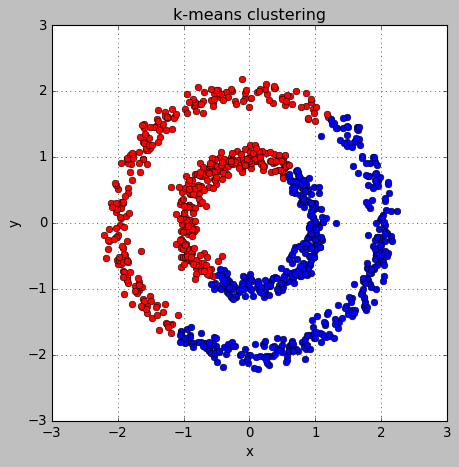

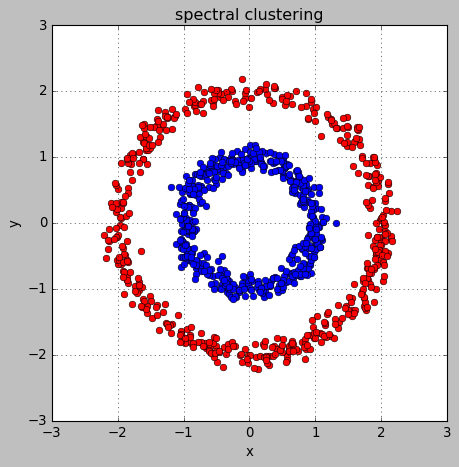

/Users/alkrasnov/anaconda3/envs/AM_ML_env/lib/python3.9/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/var/folders/3c/zb3vq_6960dbkm_ndj8dmrk40000gn/T/ipykernel_83817/587657159.py:27: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigen_values, eigen_vectors = eigh(normalized_W,
/Users/alkrasnov/anaconda3/envs/AM_ML_env/lib/python3.9/site-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


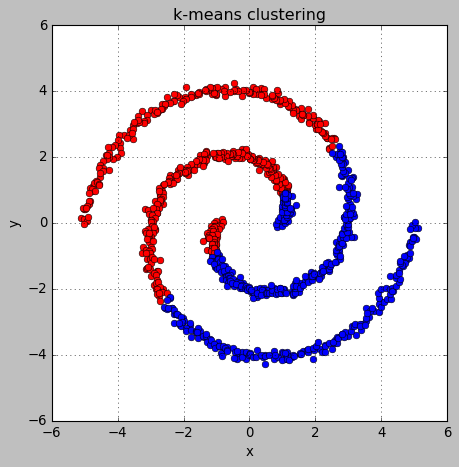

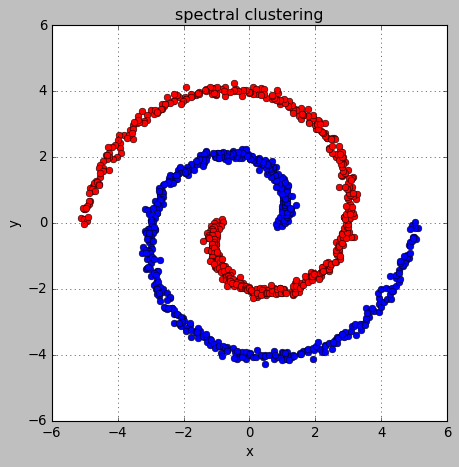

In [29]:
plt.style.use('classic')

def spectral_clustering():
    np.random.seed(0)
    num_clusters = 2
    for data_type, data in (('circle', sample_circle(num_clusters)),
                            ('spiral', sample_spiral())):
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        kmeans.fit(data)
        assignments = kmeans.predict(data)
        plot_data(data, assignments, 'k-means clustering', data_type)

        sigma = 0.1
        gamma = 1 / (2 * sigma ** 2)
        W = rbf_kernel(data, gamma=gamma)
        d = np.sum(W, 1, keepdims=True)
        sqrt_d = np.sqrt(d)

        normalized_W = (W / sqrt_d) / sqrt_d.T
        paranoid_assert(W, normalized_W, False)

        # We select the largest eigen values of normalized_W, rather
        # than the smallest eigenvalues of I - normalized_W.  The two
        # problems are equivalent. The eigen values can be converted
        # between the two problems via `1 - eigen_values`. The eigen
        # vectors are the same between both problems.
        eigen_values, eigen_vectors = eigh(normalized_W,
                                           # Get only the top num_clusters eigenvalues
                                           eigvals=(data.shape[0] - num_clusters, data.shape[0]-1))
        eigen_vectors = eigen_vectors / np.linalg.norm(eigen_vectors, axis=1, keepdims=True)

        kmeans.fit(eigen_vectors)
        assignments = kmeans.predict(eigen_vectors)
        plot_data(data, assignments, 'spectral clustering', data_type)

        plt.show()

def paranoid_assert(W, normalized_W, enable):
    if not enable:
        return
    D = np.diag(np.sum(W, 1))
    L = D - W
    D_inv_sqrt = np.diag(1 / np.diag(np.sqrt(D)))
    np.testing.assert_almost_equal(np.sum(L, 1), 0, err_msg="Rows of Laplacian must sum to 0.")
    np.testing.assert_allclose(normalized_W, D_inv_sqrt * W * D_inv_sqrt, rtol=0, atol=1)

def sample_circle(num_clusters):
    points_per_cluster = 500
    bandwidth = 0.1

    data = np.zeros((num_clusters * points_per_cluster, 2))
    for k, n in itertools.product(range(num_clusters), range(points_per_cluster)):
        theta = 2 * np.pi * np.random.uniform()
        rho = k + 1 + np.random.randn() * bandwidth
        x, y = pol2cart(theta, rho)
        idx = k * points_per_cluster + n
        data[idx, 0] = x
        data[idx, 1] = y
    data = data.reshape((num_clusters * points_per_cluster, 2))
    return data

def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return(x, y)

def sample_spiral():
    # Only 2 clusters in this case. This is hard-coded.
    points_per_cluster = 500
    bandwidth = 0.1

    data = np.empty((points_per_cluster, 2))

    w = np.arange(1, points_per_cluster + 1).astype(np.float32) / points_per_cluster
    data[:,0] = (4 * w + 1) * np.cos(2*np.pi * w) + np.random.randn(points_per_cluster) * bandwidth
    data[:,1] = (4 * w + 1) * np.sin(2*np.pi * w) + np.random.randn(points_per_cluster) * bandwidth
    data = np.vstack((data, -data))

    return data

def plot_data(data, assignments, title, data_type):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(data[assignments == 0, 0], data[assignments == 0, 1], 'o', color='r')
    ax.plot(data[assignments == 1, 0], data[assignments == 1, 1], 'o', color='b')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('square')
    ax.grid(True)
    ax.set_title(title)
    plt.tight_layout()
    pml.savefig(f"{data_type}_{title.replace(' ', '_')}.pdf")

if __name__ == '__main__':
    spectral_clustering()


## HDBSCAN

https://github.com/scikit-learn-contrib/hdbscan

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [30]:
import hdbscan
import seaborn as sns

In [31]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(X)

HDBSCAN(gen_min_span_tree=True)

In [32]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3])

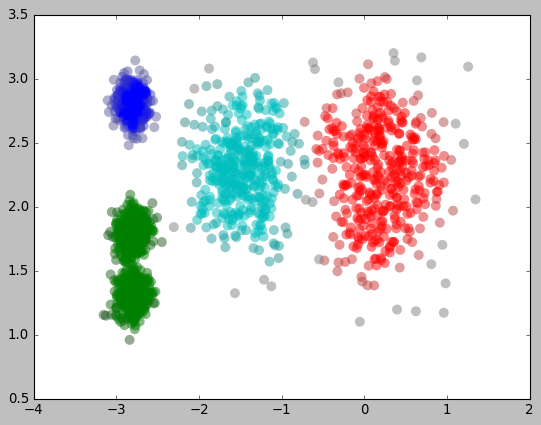

In [33]:
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(X.T[0], X.T[1], c=cluster_colors, **plot_kwds)


## Сравнение реализаций

- https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html

- https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

- https://medium.com/@sina.nazeri/comparing-the-state-of-the-art-clustering-algorithms-1e65a08157a1